In [1]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

from scipy import stats
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from random import randrange

from cycler import cycler

import re

import random
import pickle,pprint

from scipy.stats import gamma
from scipy.optimize import minimize

from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.integrate import odeint
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:


rc('text', usetex=True)

# this is just to have figure with large fontsize
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


plt.rc('font', weight='bold')
plt.rc('xtick.major', size=5, pad=7)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)




## Poisson Process with absolute refractory period

In [3]:
def RHO(tau,nu,d):
    if tau< d:
        return 0 
    else:
        return nu

def S(tau,nu,d):
    if tau <d:
        return 1
    else:
        return np.exp(-nu*(tau-d))
    
def P(tau,nu,d):
    if tau <d:
        return 0
    else:
        return nu*np.exp(-nu*(tau-d))
    
    
    

In [4]:
def phih(h,nu_max,beta,h_0):
    return nu_max*np.exp(beta*(h-h_0))


In [5]:
def Cnm(n,m,h,nu_max,beta,h_0,d):
    
    nu=phih(h,nu_max,beta,h_0)
    
    ln=eigenvalue(n,nu,d)
    lm=eigenvalue(m,nu,d)
    
    if n==m:
        return beta*ln*d*(1+0.5*d*(ln+nu))/((1+(ln+nu)*d)**2)
    else:
        return beta*(ln*(nu+lm))/((ln-lm)*(ln+nu)*(1+d*(lm+nu)))
    

def eigenvalue(n,nu,d):
    return (1/d)*sc.special.lambertw(d*nu*np.exp(nu*d), k=n)-nu

In [6]:
def phi1_0h(h,nu_max,beta,h_0,):
    nu=phih(h,nu_max,beta,h_0)
    l1=eigenvalue(1,nu,d)
    return (nu+l1)/(1+d*(nu+l1))

In [7]:
def RMS(A_n,A_th):
    return  np.sqrt(np.sum((A_n-A_th)**2)/len(A_n))

def NRMS(A_n,A_th):#,nu_i):
    #return RMS(A_n,A_th)/(nu_i)
    return RMS(A_n,A_th)/((np.amax(A_th)-np.amin(A_th)))

In [8]:
def KLM(h,X,Y,d,nu_max,beta,h_0,tau_m,t):
    nu=phih(h,nu_max,beta,h_0)
    l1=eigenvalue(1,nu,d)
    C11=Cnm(1,1,h,nu_max,beta,h_0,d)
    C10=Cnm(1,0,h,nu_max,beta,h_0,d)
    C1_1=Cnm(1,-1,h,nu_max,beta,h_0,d)
    
    hpoint=1/tau_m*(-h+mu(t))
    
    
    f=l1+(C11+C1_1)*hpoint
    g=l1+(C11-C1_1)*hpoint
    
    
    
    K=f.real*X-g.imag*Y+C10.real*hpoint
    L=f.imag*X+g.real*Y+C10.imag*hpoint
    M=1/tau_m*(-h+mu(t))

    
    return K,L,M


def KLM_coupled(h,X,Y,d,nu_max,beta,h_0,tau_m,J,t):
    nu=phih(h,nu_max,beta,h_0)
    l1=eigenvalue(1,nu,d)
    C11=Cnm(1,1,h,nu_max,beta,h_0,d)
    C10=Cnm(1,0,h,nu_max,beta,h_0,d)
    C1_1=Cnm(1,-1,h,nu_max,beta,h_0,d)
    
    phi1_0= phi1_0h(h,nu_max,beta,h_0,d)
    A_inf=nu/(d*nu+1)       
    A=A_inf+2*(X*phi1_0.real-Y*phi1_0.imag)
            
    
    hpoint=1/tau_m*(-h+mu(t)+J*A)
    
    
    f=l1+(C11+C1_1)*hpoint
    g=l1+(C11-C1_1)*hpoint
    
    
    K=f.real*X-g.imag*Y+C10.real*hpoint
    L=f.imag*X+g.real*Y+C10.imag*hpoint
    M=hpoint

    
    return K,L,M
    
    

In [19]:
n=1
m=-1
h=10

print(Cnm(n,m,h,nu_max,beta,h_0,d))

(-0.00837136745529-0.156265770235j)


# SINUSOIDAL Input : UNCOUPLED

In [9]:

#PARAMETERS:

#SIMULATION PARAMETERS

dt=0.05
t_max=200
N_sim=int(t_max/dt)
tsim=[i*dt for i in range(N_sim)]
tsim_num=[i*dt for i in range(N_sim)]
#----------------------------------------------------------

#NEURON PARAMETER:

d=10 #ms
tau_m=15 #ms
#----------------------------------------------------------

#RECOVERY FUNCTION PARAMETERS Phi(h)=nu_max*exp(beta(h-h0)):

beta=1 #mv^(-1)
nu_max=0.05 #kHZ : firing rate for h=h_0 
h_0=15 #mV
#----------------------------------------------------------


#EXTERNAL INPUT:  mu(t)=mu_1+epsilon*sin(omega*t)
#different frequency trials
fr_vec=np.logspace(-3,0,20) #KHz  
omega_vec=2*np.pi*fr_vec #kHz  

#different epsilon trials
epsilon_vec=np.copy([5])#  #mV


#baseline of the external input 
mu_1=h_0 #mV 
#----------------------------------------------------------

#TO STORE THE ACTIVITY and the external INPUT:

mu_Matrix  =np.zeros((len(omega_vec),len(epsilon_vec),N_sim))
A_Matrix   =np.zeros((len(omega_vec),len(epsilon_vec),N_sim))
A_wc_Matrix=np.zeros((len(omega_vec),len(epsilon_vec),N_sim))
rate_ep_Matrix=np.zeros((len(omega_vec),len(epsilon_vec),N_sim))
#----------------------------------------------------------

In [11]:
eigenvalue_list=[]
C11_list=[]
C1_1_list=[]

for i_o, omega in enumerate(omega_vec):
    for i_e, epsilon in enumerate(epsilon_vec):
        
        def mu(t):
            return mu_1 - epsilon*np.sin(omega*t)
            
        
        print('omega:', omega,'epsilon',epsilon)
        
        # H PARMETER
        H=np.zeros((N_sim+1,1))
        H[0]=h_0  
        
         # H PARMETER
        h_wc=np.zeros((N_sim+1,1))
        h_wc[0]=h_0  
        
       
        # nu vecteur
        nu_0=phih(H[0],nu_max,beta,h_0)        
        
        A=np.zeros((N_sim,1))
        A[0]=nu_0/(1+d*nu_0)

        A_wc=np.zeros((N_sim+1,1))
        A_wc[0]=nu_0/(1+d*nu_0)
        
        rate_ep=np.zeros((N_sim+1,1))
        rate_ep[0]=nu_0/(1+d*nu_0)
        
    
        X=np.zeros((N_sim+1,1))  # X in the thesis
        Y=np.zeros((N_sim+1,1)) # Y in the thesis
    
        d_index=int(d/dt)

        for i in range(N_sim-1):
            t=i*dt
        
              
            mu_Matrix[i_o,i_e,i]=mu(t)
             
            
            #TO COMPUTE THE Theoretical  WC
            if i<d_index:
                jstart=0
                first_A=d_index-i-1
            else:
                jstart=i-d_index+1
                first_A=0
            
            hpoint_wc=1/tau_m*(-h_wc[i]+mu(t))
            h_wc[i+1]=h_wc[i]+dt*hpoint_wc
            
            nu_wc=phih(h_wc[i],nu_max,beta,h_0)
            
            A_wc[i+1]=nu_wc*(1-(np.sum(A_wc[jstart:i+1])+first_A*A_wc[0])*dt)
            rate_ep[i+1]=nu_wc/(1+d*nu_wc)
            
            
            K1,L1,M1=KLM(H[i],X[i],Y[i],d,nu_max,beta,h_0,tau_m,t)
            K2,L2,M2=KLM(H[i]+0.5*dt*M1,X[i]+0.5*dt*K1,Y[i]+0.5*dt*L1,d,nu_max,beta,h_0,tau_m,t)
            K3,L3,M3=KLM(H[i]+0.5*dt*M2,X[i]+0.5*dt*K2,Y[i]+0.5*dt*L2,d,nu_max,beta,h_0,tau_m,t)
            K4,L4,M4=KLM(H[i]+dt*M3,X[i]+dt*K3,Y[i]+dt*L3,d,nu_max,beta,h_0,tau_m,t)
            
        
            X[i+1]=X[i]+dt/6*(K1+2*K2+2*K3+K4)
            Y[i+1]=Y[i]+dt/6*(L1+2*L2+2*L3+L4)
            H[i+1]=H[i]+dt/6*(M1+2*M2+2*M3+M4)
            
            
            
            phi1_0= phi1_0h(H[i+1],nu_max,beta,h_0,d)
            
            nu=phih(H[i+1],nu_max,beta,h_0)
         
            A_inf=nu/(d*nu+1)
            A[i+1]=A_inf+2*(X[i+1]*phi1_0.real-Y[i+1]*phi1_0.imag)
            
           
        
        
        A_wc=A_wc[:-1]
        rate_ep=rate_ep[:-1]
    
        
    
        A_Matrix[i_o,i_e,:]=A.flatten()
        A_wc_Matrix[i_o,i_e,:]=A_wc.flatten()
        rate_ep_Matrix[i_o,i_e,:]=rate_ep.flatten()
    

omega: 0.00628318530718 epsilon 5
omega: 0.0090380472032 epsilon 5
omega: 0.0130007779898 epsilon 5
omega: 0.0187009676471 epsilon 5
omega: 0.0269004048228 epsilon 5
omega: 0.0386948843122 epsilon 5
omega: 0.0556606520162 epsilon 5
omega: 0.0800650586748 epsilon 5
omega: 0.115169574706 epsilon 5
omega: 0.165665661871 epsilon 5
omega: 0.238301752811 epsilon 5
omega: 0.34278512971 epsilon 5
omega: 0.493079231537 epsilon 5
omega: 0.709269765522 epsilon 5
omega: 1.02024901498 epsilon 5
omega: 1.46757708163 epsilon 5
omega: 2.11103608912 epsilon 5
omega: 3.03661962656 epsilon 5
omega: 4.3680251626 epsilon 5
omega: 6.28318530718 epsilon 5


In [27]:
omega_search  = {'epsilon_vec': epsilon_vec,
               'omega_vec': omega_vec,
               'mu_Matrix': mu_Matrix,
               'A_Matrix': A_Matrix,
               'A_wc_Matrix': A_wc_Matrix,
                'rate_ep_Matrix': rate_ep_Matrix,
                'tsim':tsim,
                'fr_vec':fr_vec,
                 'mu_1':mu_1
              }

output = open('omega_search.pkl', 'wb')

pickle.dump(omega_search, output)

output.close()

In [28]:
#pkl_file = open('omega_search.pkl', 'rb')

#omega_search = pickle.load(pkl_file)

#pkl_file.close()

#omega_vec=omega_search['omega_vec']
#fr_vec=omega_search['fr_vec']
#A_Matrix=omega_search['A_Matrix']
#A_wc_Matrix=omega_search['A_wc_Matrix']
#tsim=omega_search['tsim']
#epsilon_vec=omega_search['epsilon_vec']

In [14]:
NRMS_matrix=np.zeros((len(omega_vec),len(epsilon_vec)))

for i_o, omega in enumerate(omega_vec):
    for i_e, epsilon in enumerate(epsilon_vec):
        NRMS_matrix[i_o,i_e]=NRMS(A_Matrix[i_o,i_e,:],A_wc_Matrix[i_o,i_e,:])
        

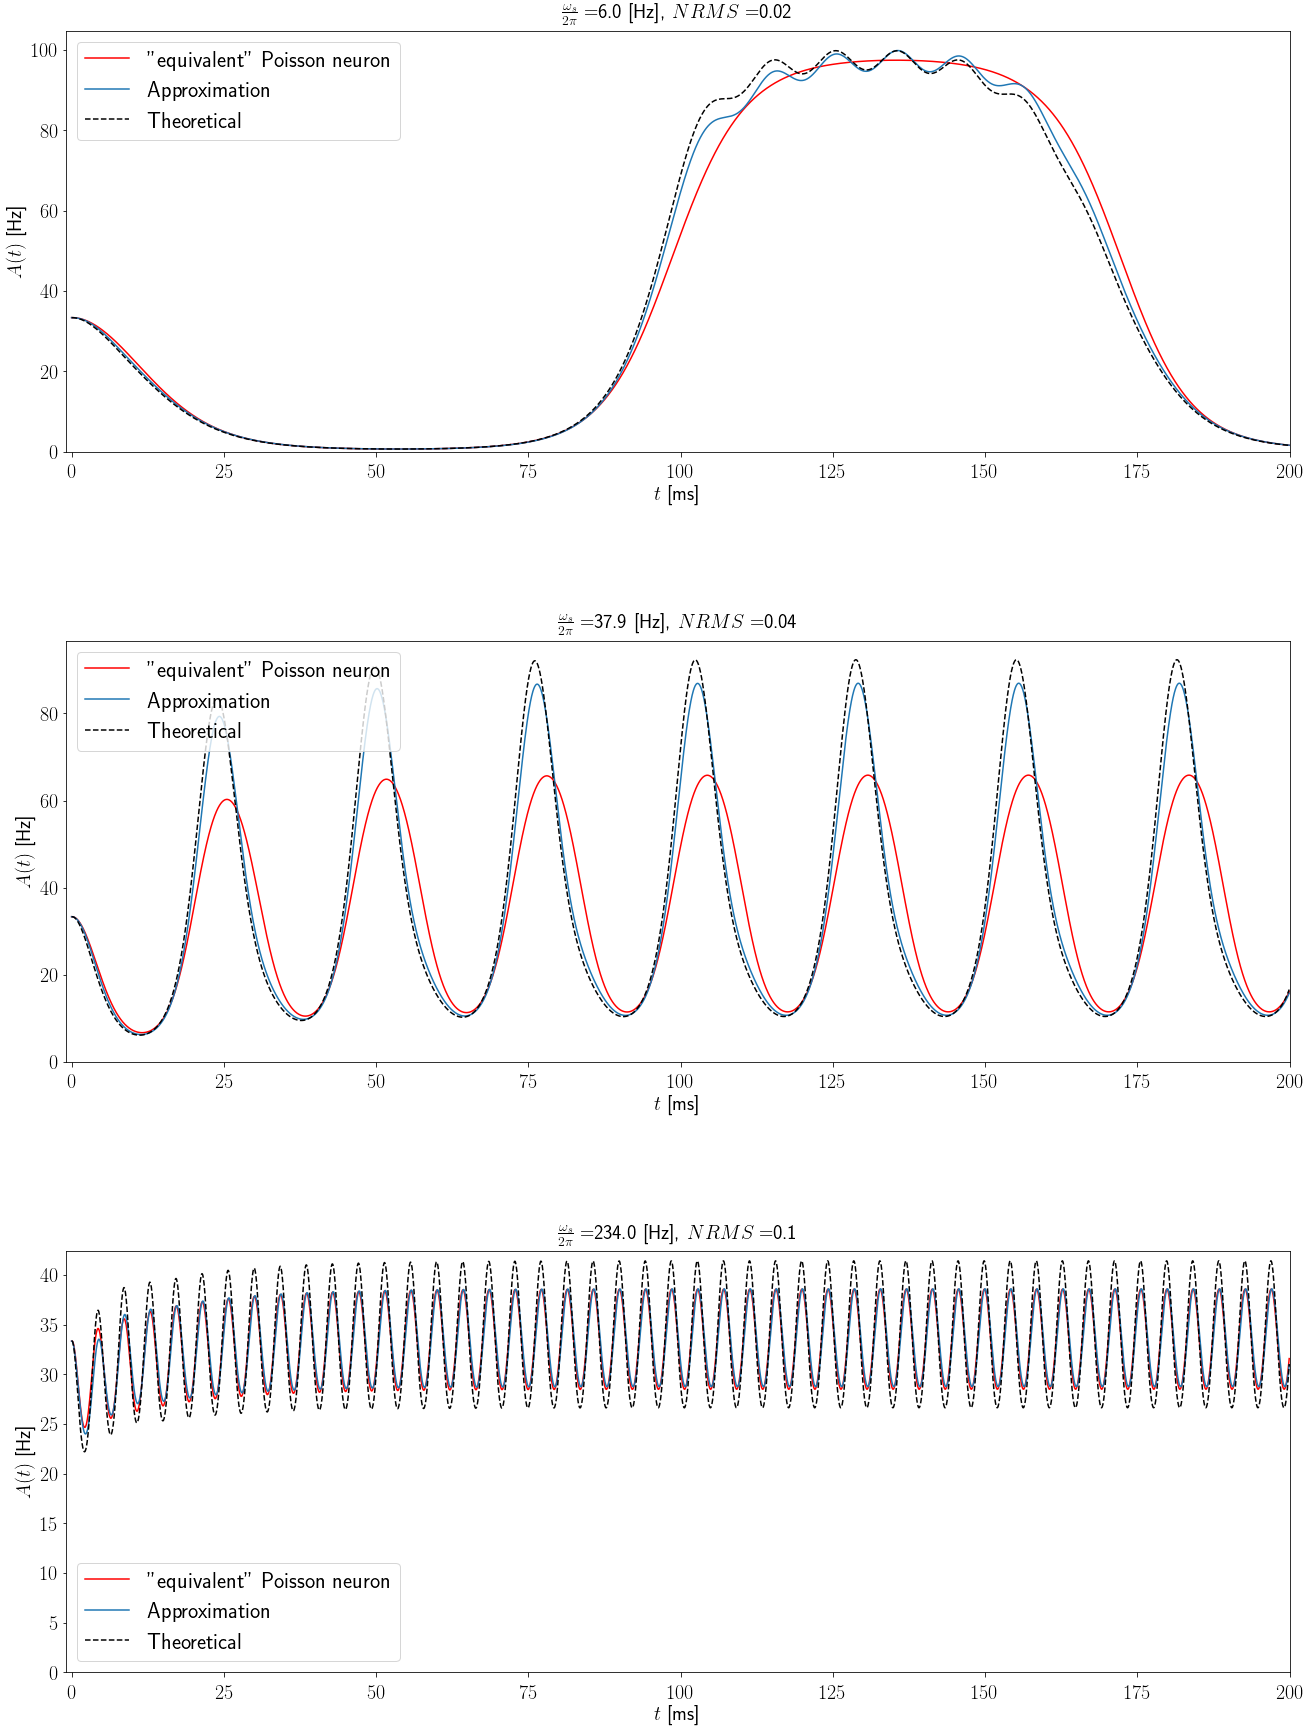

In [15]:


plt.figure(figsize=(20,30))

i_o=5
i_e=0
plt.subplot(311)
plt.plot(tsim,1000*rate_ep_Matrix[i_o,i_e,:],label='"equivalent" Poisson neuron',c='r',ls='-')
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='Approximation')
plt.plot(tsim,1000*A_wc_Matrix[i_o,i_e,:],label='Theoretical',c='k',ls='--')

plt.title(r'$\frac{\omega_s}{2\pi}=$'+str(np.round(1000*fr_vec[i_o],0))+' [Hz], $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
#, $\epsilon=$'+str(epsilon)+ r' [mV] $
plt.legend(fontsize=22)
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)


plt.subplot(312)
i_o=10
i_e=0
plt.plot(tsim,1000*rate_ep_Matrix[i_o,i_e,:],label='"equivalent" Poisson neuron',c='r',ls='-')
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='Approximation')
plt.plot(tsim,1000*A_wc_Matrix[i_o,i_e,:],label='Theoretical',c='k',ls='--')
plt.title(r'$\frac{\omega_s}{2\pi}=$'+str(np.round(1000*fr_vec[i_o],1))+' [Hz], $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
#, $\epsilon=$'+str(epsilon)+ r' [mV] $
plt.legend(fontsize=22)
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)


i_o=15
i_e=0

plt.subplot(313)
plt.plot(tsim,1000*rate_ep_Matrix[i_o,i_e,:],label='"equivalent" Poisson neuron',c='r',ls='-')
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='Approximation')
plt.plot(tsim,1000*A_wc_Matrix[i_o,i_e,:],label='Theoretical',c='k',ls='--')
plt.title(r'$\frac{\omega_s}{2\pi}=$'+str(np.round(1000*fr_vec[i_o],0))+' [Hz], $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
#, $\epsilon=$'+str(epsilon)+ r' [mV] $
plt.legend(fontsize=22)
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)

plt.subplots_adjust(top=0.88, bottom=0.12, left=0.10, right=0.95, hspace=0.45,
                    wspace=0.45)
plt.savefig('A_omega_t.pdf')

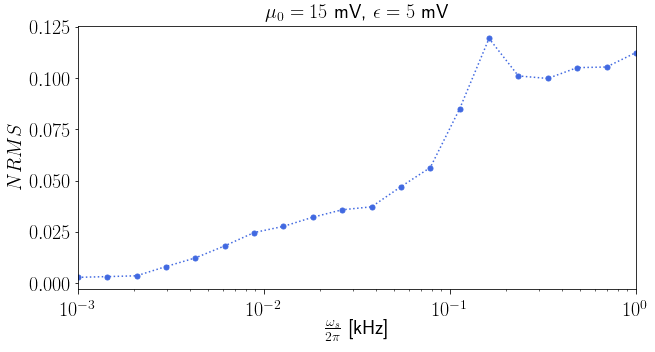

In [15]:
plt.figure(figsize=(10, 5))
colorv=['royalblue','g','r']
for i_e, epsilon in enumerate(epsilon_vec):
    plt.semilogx(fr_vec,NRMS_matrix[:,i_e],ls=':',marker='o',ms='5',c=colorv[i_e])#,label=r'$\epsilon=$'+str(epsilon)+r' $mV$')
plt.ylabel(r'$NRMS$ ')
plt.xlabel(r'$\frac{\omega_s}{2\pi}$ [kHz]')
plt.title(r'$\mu_0=15$ mV, $\epsilon=5 $ mV')

#plt.legend(loc='upper left',fontsize='20')

plt.xlim(0,1)

plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig('NRMSo.pdf')

In [16]:
# TODO CHOOSE THREE FIGURE AND TO THE PLOT

# STEP FUNCTION UNCOUPLED

In [16]:
#PARAMETERS:

#SIMULATION PARAMETERS
dt=0.05
t_max=500
N_sim=int(t_max/dt)
tsim=[i*dt for i in range(N_sim)]
tsim_num=[i*dt for i in range(N_sim)]
#----------------------------------------------------------

#NEURON PARAMETER:

d=10 #ms
tau_m=15 #ms
#----------------------------------------------------------

#RECOVERY FUNCTION PARAMETERS Phi(h)=nu_max*exp(beta(h-h0)):

beta=1 #mv^(-1)
nu_max=0.05 #kHZ : firing rate for h=h_0 
h_0=15 #mV
#----------------------------------------------------------


#EXTERNAL INPUT:  mu(t)=mu_1+epsilon*sin(omega*t)
#different frequency trials
fr_vec=np.logspace(-3,0,10) #KHz  
omega_vec=2*np.pi*fr_vec #kHz  

#different epsilon trials
epsilon_vec=np.copy([5])#  #mV


#baseline of the external input 
mu_1=h_0 #mV 
#------------------------------------------------------------

#TO STORE THE ACTIVITY and the external INPUT:

mu_Matrix  =np.zeros(N_sim+1)


In [17]:
def mu(t):
    if t<5:
        return h_0
    
    elif t<100:
        
        return h_0+5
            
    elif t<200:
        return h_0-5
        
    elif t<300:
        return h_0+5
 
    else:
        return h_0+2
            

In [18]:
# H PAREMETER
H=np.zeros((N_sim+1,1))
H[0]=h_0  
        
# H PAREMETER
h_wc=np.zeros((N_sim+1,1))
h_wc[0]=h_0  
        
# nu vecteur
nu_0=phih(H[0],nu_max,beta,h_0)        
        
A=np.zeros((N_sim,1))
A[0]=nu_0/(1+d*nu_0)

A_wc=np.zeros((N_sim+1,1))
A_wc[0]=nu_0/(1+d*nu_0)

rate_ep=np.zeros((N_sim+1,1))
rate_ep[0]=nu_0/(1+d*nu_0)

    
X=np.zeros((N_sim+1,1))  # X in the thesis
Y=np.zeros((N_sim+1,1))  # Y in the thesis
    
d_index=int(d/dt)

for i in range(N_sim-1):
    t=i*dt
        
              
    mu_Matrix[i]=mu(t)
             
        
    #TO COMPUTE THE Theoretical  WC
    if i<d_index:
        jstart=0
        first_A=d_index-i-1
    else:
        jstart=i-d_index+1
        first_A=0
            
    hpoint_wc=1/tau_m*(-h_wc[i]+mu(t))
    h_wc[i+1]=h_wc[i]+dt*hpoint_wc
            
    nu_wc=phih(h_wc[i],nu_max,beta,h_0)
            
    A_wc[i+1]=nu_wc*(1-(np.sum(A_wc[jstart:i+1])+first_A*A_wc[0])*dt)
    rate_ep[i+1]=nu_wc/(1+d*nu_wc)
            
            
    K1,L1,M1=KLM(H[i],X[i],Y[i],d,nu_max,beta,h_0,tau_m,t)
    K2,L2,M2=KLM(H[i]+0.5*dt*M1,X[i]+0.5*dt*K1,Y[i]+0.5*dt*L1,d,nu_max,beta,h_0,tau_m,t)
    K3,L3,M3=KLM(H[i]+0.5*dt*M2,X[i]+0.5*dt*K2,Y[i]+0.5*dt*L2,d,nu_max,beta,h_0,tau_m,t)
    K4,L4,M4=KLM(H[i]+dt*M3,X[i]+dt*K3,Y[i]+dt*L3,d,nu_max,beta,h_0,tau_m,t)
            
        
    X[i+1]=X[i]+dt/6*(K1+2*K2+2*K3+K4)
    Y[i+1]=Y[i]+dt/6*(L1+2*L2+2*L3+L4)
    H[i+1]=H[i]+dt/6*(M1+2*M2+2*M3+M4)
            
            
            
    phi1_0= phi1_0h(H[i+1],nu_max,beta,h_0,d)
            
    nu=phih(H[i+1],nu_max,beta,h_0)
         
    A_inf=nu/(d*nu+1)
    A[i+1]=A_inf+2*(X[i+1]*phi1_0.real-Y[i+1]*phi1_0.imag)
            
           
        
        
A_wc=A_wc[:-1]
rate_ep=rate_ep[:-1]
        

    

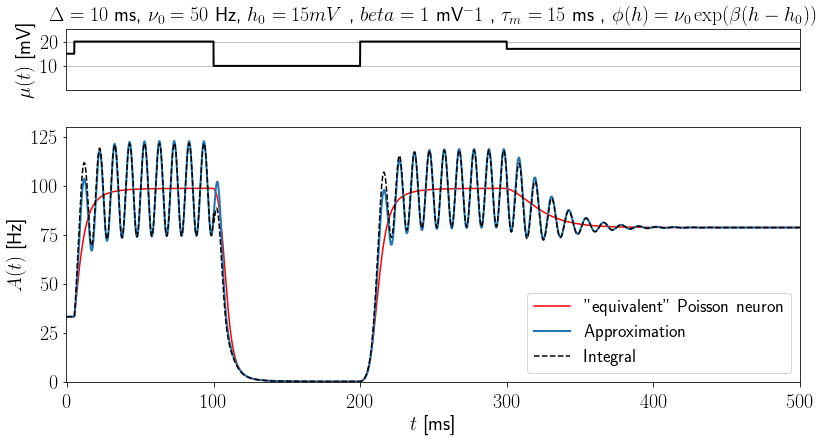

In [19]:

plt.figure(figsize=(12, 7))


gridspec.GridSpec(4,1)
plt.subplot2grid((4,1), (0,0))
plt.title(r'$\Delta=10$ ms, $\nu_0=50$ Hz, $h_0=15 mV$ , $beta=1$ mV$^-1$ , $\tau_m=15$ ms , $\phi(h)=\nu_0\exp(\beta(h-h_0))$')

plt.plot(tsim,[mu(t) for t in tsim],lw=2,c='k')
plt.xlim(-1,t_max)
plt.ylim(0,25)
plt.xticks([], [])
plt.yticks([10,20])
plt.grid()
plt.ylabel(r'$\mu(t)$ [mV]')

plt.subplot2grid((4,1), (1,0),colspan=1, rowspan=3)
plt.plot(tsim,1000*rate_ep,label='"equivalent" Poisson neuron',c='r',ls='-')
plt.plot(tsim,1000*A,label='Approximation',lw=2)
plt.plot(tsim_num,1000*A_wc,label='Integral',c='k',ls='--')
plt.legend(fontsize=18,loc='lower right')
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)
plt.ylim(0,130)
        
        
plt.subplots_adjust(top=0.9, bottom=0.2, left=0.10, right=0.95, hspace=0.6,
                    wspace=0.45)



plt.savefig('step.pdf')


# SINUSOIDAL Input : COUPLED

In [20]:

#PARAMETERS:

#SIMULATION PARAMETERS

dt=0.05
t_max=200
N_sim=int(t_max/dt)
tsim=[i*dt for i in range(N_sim)]
tsim_num=[i*dt for i in range(N_sim)]
#----------------------------------------------------------

#NEURON PARAMETER:

d=10 #ms
tau_m=15 #ms
J=20  #mV/kHz #coupling constant


#----------------------------------------------------------

#RECOVERY FUNCTION PARAMETERS Phi(h)=nu_max*exp(beta(h-h0)):

beta=1 #mv^(-1)
nu_max=0.05 #kHZ : firing rate for h=h_0 
h_0=15 #mV
#----------------------------------------------------------

#COUPLING CONTANT


#EXTERNAL INPUT:  mu(t)=mu_1+epsilon*sin(omega*t)
#different frequency trials
fr_vec=np.logspace(-3,0,20) #KHz  
omega_vec=2*np.pi*fr_vec #kHz  

#different epsilon trials
epsilon_vec=np.copy([5])#  #mV


#baseline of the external input 
mu_1=h_0 #mV 
#----------------------------------------------------------

#TO STORE THE ACTIVITY and the external INPUT:

mu_Matrix  =np.zeros((len(omega_vec),len(epsilon_vec),N_sim))
A_Matrix   =np.zeros((len(omega_vec),len(epsilon_vec),N_sim))
A_wc_Matrix=np.zeros((len(omega_vec),len(epsilon_vec),N_sim))
rate_ep_Matrix=np.zeros((len(omega_vec),len(epsilon_vec),N_sim))
#----------------------------------------------------------



In [21]:


for i_o, omega in enumerate(omega_vec):
    for i_e, epsilon in enumerate(epsilon_vec):
        
        def mu(t):
            return mu_1 - epsilon*np.sin(omega*t)
            
        
        print('omega:', omega,'epsilon',epsilon)
        
        # H PARMETER
        H=np.zeros((N_sim+1,1))
        H[0]=h_0  
        
         # H PARMETER
        h_wc=np.zeros((N_sim+1,1))
        h_wc[0]=h_0  
        
       
        # nu vecteur
        nu_0=phih(H[0],nu_max,beta,h_0)        
        
        A=np.zeros((N_sim,1))
        A[0]=nu_0/(1+d*nu_0)

        A_wc=np.zeros((N_sim+1,1))
        A_wc[0]=nu_0/(1+d*nu_0)
        
        rate_ep=np.zeros((N_sim+1,1))
        rate_ep[0]=nu_0/(1+d*nu_0)
        
    
        X=np.zeros((N_sim+1,1))  # X in the thesis
        Y=np.zeros((N_sim+1,1)) # Y in the thesis
    
        d_index=int(d/dt)

        for i in range(N_sim-1):
            t=i*dt
        
              
            mu_Matrix[i_o,i_e,i]=mu(t)
             
            
            
            #TO COMPUTE THE Theoretical  WC
            if i<d_index:
                jstart=0
                first_A=d_index-i-1
            else:
                jstart=i-d_index+1
                first_A=0
            
            hpoint_wc=1/tau_m*(-h_wc[i]+mu(t)+J*A_wc[i])
            h_wc[i+1]=h_wc[i]+dt*hpoint_wc
            
            nu_wc=phih(h_wc[i],nu_max,beta,h_0)
            
            A_wc[i+1]=nu_wc*(1-(np.sum(A_wc[jstart:i+1])+first_A*A_wc[0])*dt)
            rate_ep[i+1]=nu_wc/(1+d*nu_wc)
            
            
            K1,L1,M1=KLM_coupled(H[i],X[i],Y[i],d,nu_max,beta,h_0,tau_m,J,t)
            K2,L2,M2=KLM_coupled(H[i]+0.5*dt*M1,X[i]+0.5*dt*K1,Y[i]+0.5*dt*L1,d,nu_max,beta,h_0,tau_m,J,t)
            K3,L3,M3=KLM_coupled(H[i]+0.5*dt*M2,X[i]+0.5*dt*K2,Y[i]+0.5*dt*L2,d,nu_max,beta,h_0,tau_m,J,t)
            K4,L4,M4=KLM_coupled(H[i]+dt*M3,X[i]+dt*K3,Y[i]+dt*L3,d,nu_max,beta,h_0,tau_m,J,t)
            
            
            X[i+1]=X[i]+dt/6*(K1+2*K2+2*K3+K4)
            Y[i+1]=Y[i]+dt/6*(L1+2*L2+2*L3+L4)
            H[i+1]=H[i]+dt/6*(M1+2*M2+2*M3+M4)
            
            
            phi1_0= phi1_0h(H[i+1],nu_max,beta,h_0,d)
            
            nu=phih(H[i+1],nu_max,beta,h_0)
         
            A_inf=nu/(d*nu+1)
            A[i+1]=A_inf+2*(X[i+1]*phi1_0.real-Y[i+1]*phi1_0.imag)
            
           
        
        
        A_wc=A_wc[:-1]
        rate_ep=rate_ep[:-1]
    
        
    
        A_Matrix[i_o,i_e,:]=A.flatten()
        A_wc_Matrix[i_o,i_e,:]=A_wc.flatten()
        rate_ep_Matrix[i_o,i_e,:]=rate_ep.flatten()
    

omega: 0.00628318530718 epsilon 5
omega: 0.0090380472032 epsilon 5
omega: 0.0130007779898 epsilon 5
omega: 0.0187009676471 epsilon 5
omega: 0.0269004048228 epsilon 5
omega: 0.0386948843122 epsilon 5
omega: 0.0556606520162 epsilon 5
omega: 0.0800650586748 epsilon 5
omega: 0.115169574706 epsilon 5
omega: 0.165665661871 epsilon 5
omega: 0.238301752811 epsilon 5
omega: 0.34278512971 epsilon 5
omega: 0.493079231537 epsilon 5
omega: 0.709269765522 epsilon 5
omega: 1.02024901498 epsilon 5
omega: 1.46757708163 epsilon 5
omega: 2.11103608912 epsilon 5
omega: 3.03661962656 epsilon 5
omega: 4.3680251626 epsilon 5
omega: 6.28318530718 epsilon 5


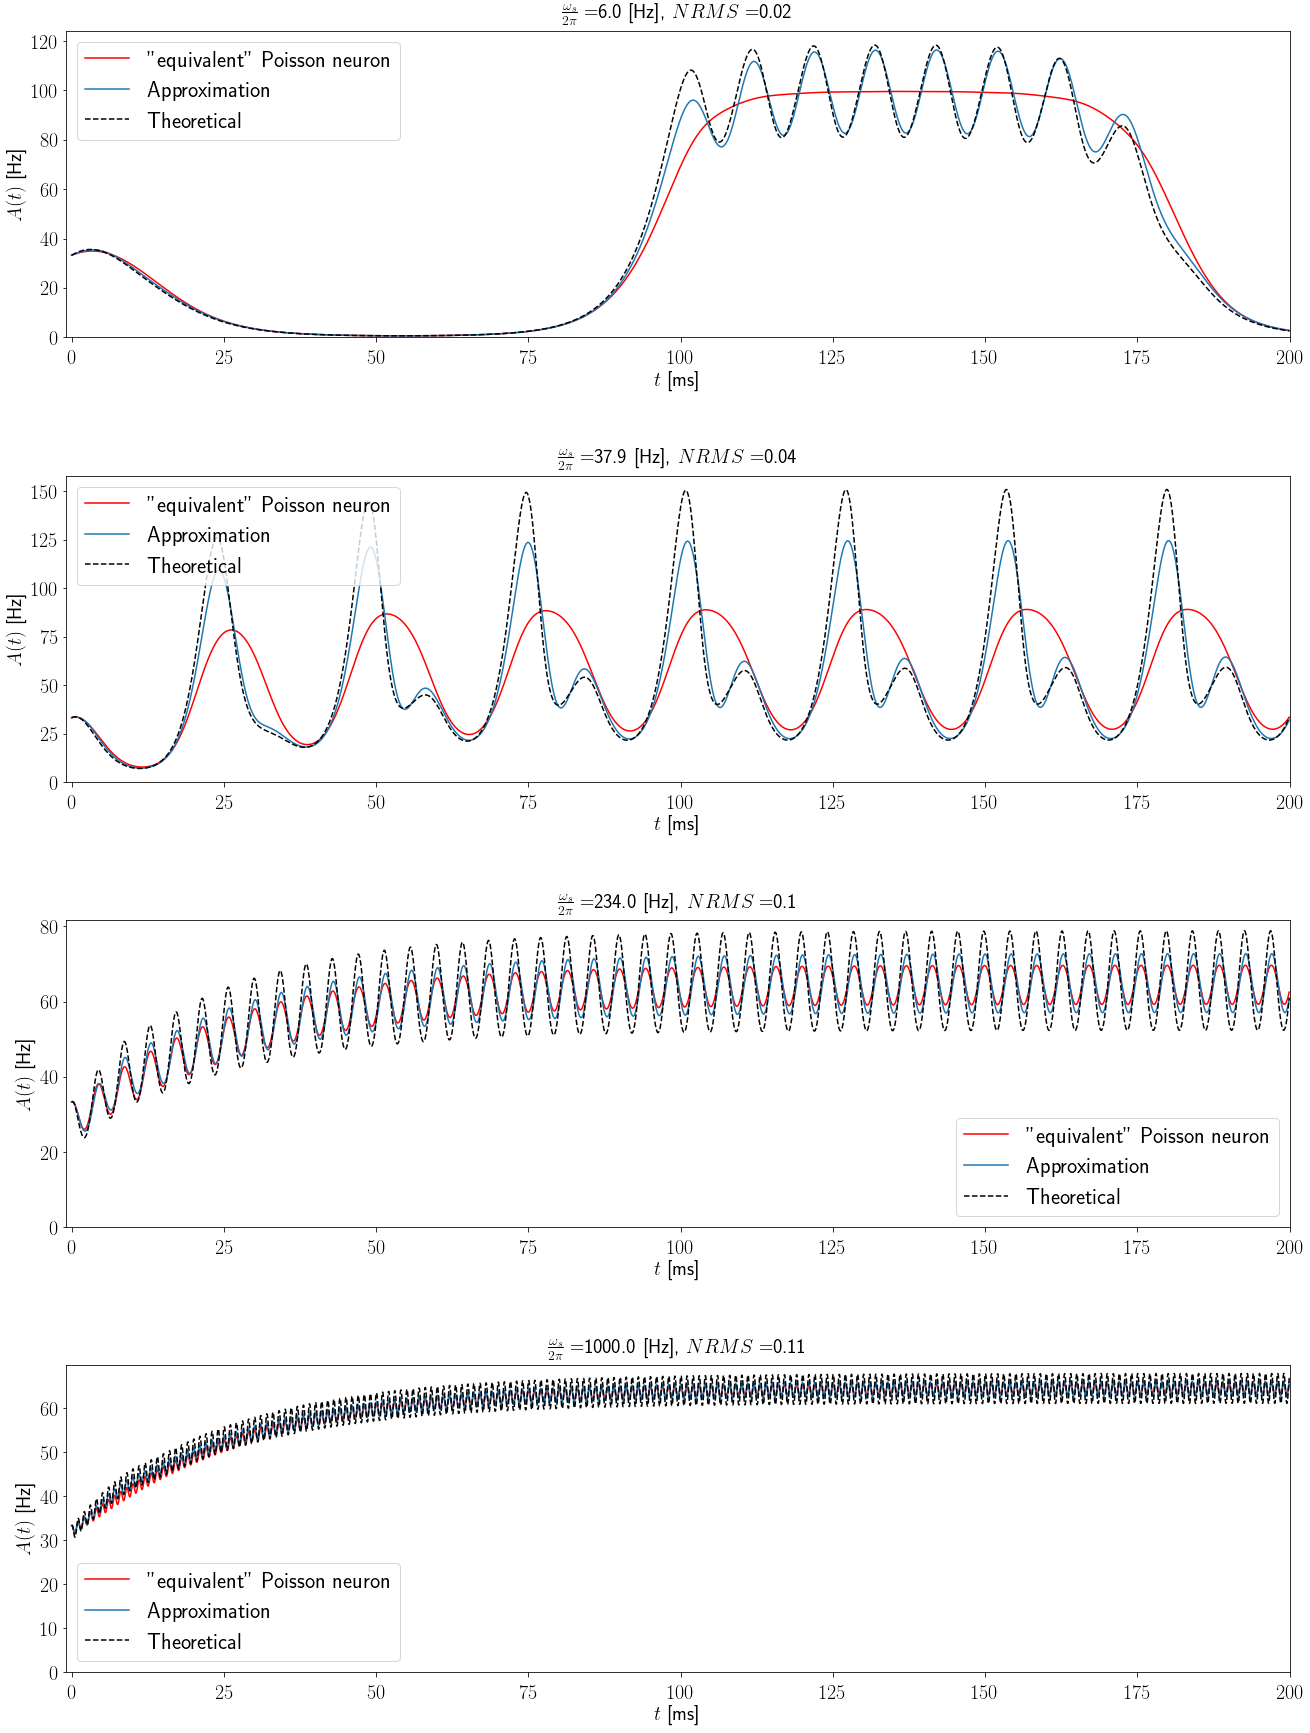

In [22]:
plt.figure(figsize=(20,30))

i_o=5
i_e=0
plt.subplot(411)
plt.plot(tsim,1000*rate_ep_Matrix[i_o,i_e,:],label='"equivalent" Poisson neuron',c='r',ls='-')
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='Approximation')
plt.plot(tsim,1000*A_wc_Matrix[i_o,i_e,:],label='Theoretical',c='k',ls='--')
plt.title(r'$\frac{\omega_s}{2\pi}=$'+str(np.round(1000*fr_vec[i_o],0))+' [Hz], $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
#, $\epsilon=$'+str(epsilon)+ r' [mV] $
plt.legend(fontsize=22)
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)


plt.subplot(412)
i_o=10
i_e=0
plt.plot(tsim,1000*rate_ep_Matrix[i_o,i_e,:],label='"equivalent" Poisson neuron',c='r',ls='-')
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='Approximation')
plt.plot(tsim,1000*A_wc_Matrix[i_o,i_e,:],label='Theoretical',c='k',ls='--')
plt.title(r'$\frac{\omega_s}{2\pi}=$'+str(np.round(1000*fr_vec[i_o],1))+' [Hz], $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
#, $\epsilon=$'+str(epsilon)+ r' [mV] $
plt.legend(fontsize=22)
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)


i_o=15
i_e=0
plt.subplot(413)
plt.plot(tsim,1000*rate_ep_Matrix[i_o,i_e,:],label='"equivalent" Poisson neuron',c='r',ls='-')
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='Approximation')
plt.plot(tsim,1000*A_wc_Matrix[i_o,i_e,:],label='Theoretical',c='k',ls='--')
plt.title(r'$\frac{\omega_s}{2\pi}=$'+str(np.round(1000*fr_vec[i_o],0))+' [Hz], $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
#, $\epsilon=$'+str(epsilon)+ r' [mV] $
plt.legend(fontsize=22)
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)


i_o=19
i_e=0
plt.subplot(414)
plt.plot(tsim,1000*rate_ep_Matrix[i_o,i_e,:],label='"equivalent" Poisson neuron',c='r',ls='-')
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='Approximation')
plt.plot(tsim,1000*A_wc_Matrix[i_o,i_e,:],label='Theoretical',c='k',ls='--')
plt.title(r'$\frac{\omega_s}{2\pi}=$'+str(np.round(1000*fr_vec[i_o],0))+' [Hz], $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
#, $\epsilon=$'+str(epsilon)+ r' [mV] $
plt.legend(fontsize=22)
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)

plt.subplots_adjust(top=0.88, bottom=0.12, left=0.10, right=0.95, hspace=0.45,
                    wspace=0.45)
plt.savefig('A_omega_coupled_t.pdf')

In [23]:
NRMS_matrix=np.zeros((len(omega_vec),len(epsilon_vec)))

for i_o, omega in enumerate(omega_vec):
    for i_e, epsilon in enumerate(epsilon_vec):
        NRMS_matrix[i_o,i_e]=NRMS(A_Matrix[i_o,i_e,:],A_wc_Matrix[i_o,i_e,:])

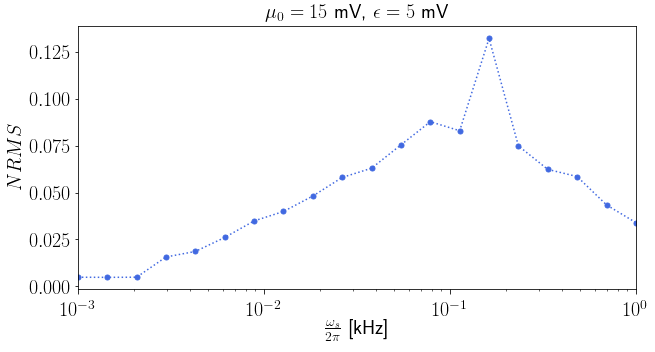

In [24]:
plt.figure(figsize=(10, 5))
colorv=['royalblue','g','r']
for i_e, epsilon in enumerate(epsilon_vec):
    plt.semilogx(fr_vec,NRMS_matrix[:,i_e],ls=':',marker='o',ms='5',c=colorv[i_e])#,label=r'$\epsilon=$'+str(epsilon)+r' $mV$')
plt.ylabel(r'$NRMS$ ')
plt.xlabel(r'$\frac{\omega_s}{2\pi}$ [kHz]')
plt.title(r'$\mu_0=15$ mV, $\epsilon=5 $ mV')

#plt.legend(loc='upper left',fontsize='20')

plt.xlim(0,1)

plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig('NRMSo_coupled.pdf')